In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

In [36]:
df = pd.read_pickle('my_df.pkl')

In [37]:
df.head(10)

,Race,Number of Deaths,Population,Crude Death Rate,Age Adjusted Death Rate,Confidence Interval,Standard Error,year
0,American Indian or Alaska Native,"1,878","2,832,761",66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,"8,976","11,346,496",79.1,125.4,1.4,0.1%,1999
2,Black or African American,"63,124","36,173,121",174.5,257.3,1.0,0.7%,1999
3,White,"489,087","228,687,790",213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,"1,959","2,984,150",65.6,130.8,3.2,0.0%,2000
5,Asian or Pacific Islander,"9,415","11,757,685",80.1,124.7,1.4,0.1%,2000
6,Black or African American,"63,081","36,594,309",172.4,253.1,1.0,0.7%,2000
7,White,"492,182","230,085,762",213.9,202.2,0.3,5.7%,2000
8,American Indian or Alaska Native,"2,213","3,097,333",71.4,140.0,3.2,0.0%,2001
9,Asian or Pacific Islander,"9,992","12,429,181",80.4,122.7,1.3,0.1%,2001


In [38]:
df.isna().sum()

Race                       0
Number of Deaths           0
Population                 0
Crude Death Rate           0
Age Adjusted Death Rate    0
Confidence Interval        0
Standard Error             0
year                       0
dtype: int64

In [39]:
# remove capitals and replace spaces with underscores in column names
old_names = list(df.columns)
formatted_names = []
for name in old_names:
    name = str.lower(name)
    name = name.replace(' ', '_')
    formatted_names.append(name)

mapper = dict(zip(old_names, formatted_names))
df.rename(mapper = mapper, axis = 1, inplace = True)
df.head()

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year
0,American Indian or Alaska Native,"1,878","2,832,761",66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,"8,976","11,346,496",79.1,125.4,1.4,0.1%,1999
2,Black or African American,"63,124","36,173,121",174.5,257.3,1.0,0.7%,1999
3,White,"489,087","228,687,790",213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,"1,959","2,984,150",65.6,130.8,3.2,0.0%,2000


In [40]:
df.dtypes

race                       object
number_of_deaths           object
population                 object
crude_death_rate           object
age_adjusted_death_rate    object
confidence_interval        object
standard_error             object
year                       object
dtype: object

In [41]:
# format data to numeric type where appropriate
df = df.apply(lambda x: x.str.replace(',',''))
columns = list(df.columns)
for column in columns:
    df[column] = pd.to_numeric(df[column], errors = 'ignore')
df.head()

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year
0,American Indian or Alaska Native,1878,2832761,66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,8976,11346496,79.1,125.4,1.4,0.1%,1999
2,Black or African American,63124,36173121,174.5,257.3,1.0,0.7%,1999
3,White,489087,228687790,213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,1959,2984150,65.6,130.8,3.2,0.0%,2000


In [42]:
df.dtypes

race                        object
number_of_deaths             int64
population                   int64
crude_death_rate           float64
age_adjusted_death_rate    float64
confidence_interval        float64
standard_error              object
year                         int64
dtype: object

In [43]:
# add column for death rate as ordinary percentage
df['death_rate'] = df['crude_death_rate'] / 1000

In [44]:
# see mean death rate grouped by race over whole time period
racial_death_rate = df[['race', 'death_rate']].groupby('race').mean()
racial_death_rate.sort_values(by = 'death_rate', ascending = False)

,death_rate
race,
White,0.207947
Black or African American,0.163773
Asian or Pacific Islander,0.081980
American Indian or Alaska Native,0.068773


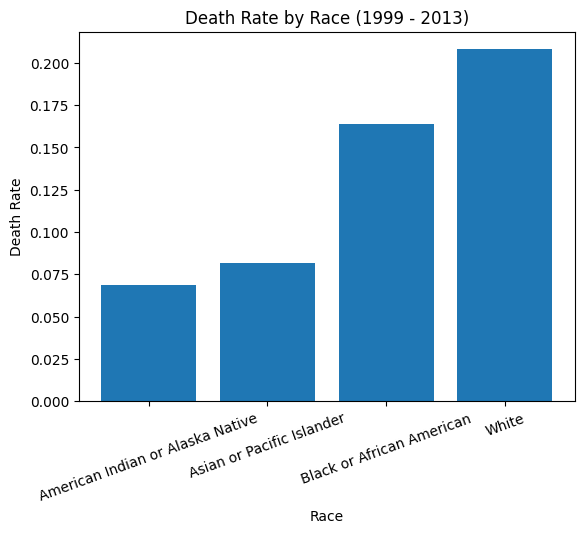

In [45]:
plt.bar(x = racial_death_rate.index, height = racial_death_rate['death_rate'])
plt.xticks(rotation = 20)
plt.title('Death Rate by Race (1999 - 2013)')
plt.ylabel('Death Rate')
plt.xlabel('Race')
plt.show()

In [46]:
racial_death_rate['death_rate'].max() - racial_death_rate.min()

death_rate    0.139173
dtype: float64

From the above bar graph we can see that the White racial group has the highest proportional death rate from cancer over the whole time period compared to all the other races. Both the White and Black or African American racial groups have a much higher death rate than the American Indian or Alaskan Native and Asian or Pacific Islander, a difference of 0.08%. The overall range of proportional deathrates was only about 0.14%, so the deathrates for each race really doesn't differ by much. We will perform an ANOVA test to see if there is a statistical difference in the death rates between the racial groups.

### Racial Death Rate ANOVA

H0: There is no difference among the death rates for each racial group.

H<sub>a</sub>: There is a difference in at least one of the racial death rates. 

Three conditions for an ANOVA test need to be established, independence of observations, normality, and homogeneity of variances. We explore these conditions.

1. Independence of observations: It is not at all the case that these racial groups are necessesarily independent. We know an individual can bear membership to more than one racial group, and even if, for the purposes of a study, a researcher wanted these groups to be exclusive, we don't know if that was established in this particular dataset. For the sake of this exercise and its pedagogical value, we will continue the test nonetheless. 
2. Normality. We use a one sample Kolmogorov-Smirnov test on each of the racial group's cancer death rates to establish normality. This test compares the empirical distribution function of a passed data set to a specified cumulative distriubtion funciton. The tests null hypothesis is that the sample distribution passed into the function (death rate of a race) is equal to the specified general distribution (normal in this case). With a standard 0.05 significance threshold
3. Variance. The variances of the group levels need to be reasonably similar. To establish this we will perform an F-test, which is simply to look at the ratio of the variances between the group with the smallest sample size, and the group with the largest sample size. If the f-score is close to one, it is assumed that these populations have equal variances. 

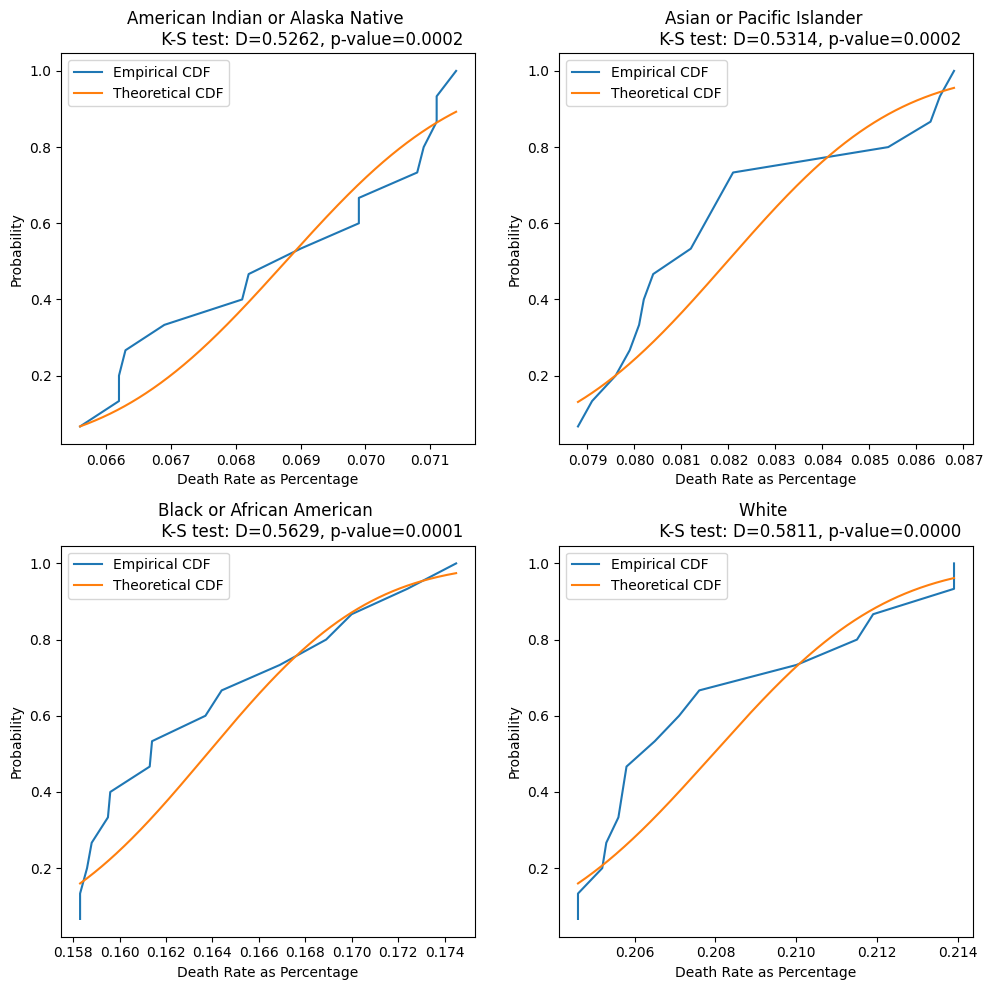

In [47]:
# Kolmogorov-Smirnov test to test for normality

races = df['race'].unique()
n = len(races)
cols = 2
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
for i, race in enumerate(races):
    ax = axs[i // cols, i % cols]

    sample = df[df['race'] == race]['death_rate']
    mean = sample.mean()
    std = sample.std()

    # Perform the K-S test against a normal distribution
    d, p_value = stats.kstest(sample, 'norm')

    # Calculate the CDFs
    x = np.sort(sample)
    y = np.arange(1, len(sample)+1) / len(sample)  # Scale y-axis to be between 0 and 1 to represent probability for empirical CDF

    x_theoretical = np.linspace(min(x), max(x), 1000) # Simulate continuous distribution of sample data
    cdf_theoretical = stats.norm.cdf(x_theoretical, mean, std)  # Use norm.cdf function to generate theoretical CDF, centered on sample's statistics

    # Plot both CDFs for comparison
    ax.plot(x, y, label='Empirical CDF')
    ax.plot(x_theoretical, cdf_theoretical, label='Theoretical CDF')
    ax.set_title(f'''{race} 
                 K-S test: D={d:.4f}, p-value={p_value:.4f}''')
    ax.legend()
    # Set labels for x and y axes
    ax.set_xlabel('Death Rate as Percentage')
    ax.set_ylabel('Probability')

# Remove empty subplots
if n % cols != 0:
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])



plt.tight_layout()
plt.show()

In [60]:
df.head()

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year,death_rate
0,American Indian or Alaska Native,1878,2832761,66.3,138.3,3.4,0.0%,1999,0.0663
1,Asian or Pacific Islander,8976,11346496,79.1,125.4,1.4,0.1%,1999,0.0791
2,Black or African American,63124,36173121,174.5,257.3,1.0,0.7%,1999,0.1745
3,White,489087,228687790,213.9,202.9,0.3,5.6%,1999,0.2139
4,American Indian or Alaska Native,1959,2984150,65.6,130.8,3.2,0.0%,2000,0.0656


In [62]:
df.columns

Index(['race', 'number_of_deaths', 'population', 'crude_death_rate',
       'age_adjusted_death_rate', 'confidence_interval', 'standard_error',
       'year', 'death_rate'],
      dtype='object')

In [55]:
# Take a look at variance to see if they're equal

variances = []
for race in df['race'].unique():
    variances.append(df[df['race'] == race]['death_rate'].var())
var_ratio = variances.min() / variances.max()
var_ratio

TypeError: could not convert string to float: 'American Indian or Alaska Native'

In [48]:
# see death rate of all races aggregated over the time period
death_rate_over_time = df[['year', 'death_rate']].groupby('year').mean()
death_rate_over_time

,death_rate
year,
1999,0.133450
2000,0.133000
2001,0.133425
2002,0.132050
2003,0.130750
2004,0.130550
2005,0.130900
2006,0.129050
2007,0.129100


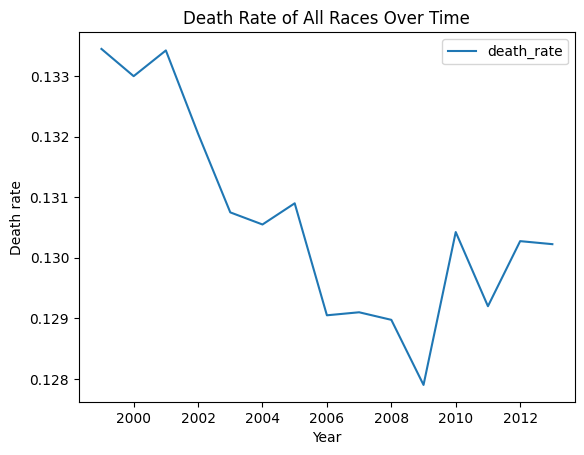

In [49]:
death_rate_over_time.plot(xlabel="Year", ylabel="Death rate", title = 'Death Rate of All Races Over Time')
plt.show()

The mean death rate of all races over the time period seems to have a downward trend between the years of 1999 and 2009, after which it looks like it picks back up. 

Let's look at a linear regression t test to see if time and cancer deaths are linearly related. While the graphs strongly suggest an inverse relationship between time and death rate, at least between the years of 1999 and 2009, we have a hunch that cancer death rates are actually going up. Therefore we will perform a two sided t test, and not specify the direction of the linear relationship in our alternative hypothesis.

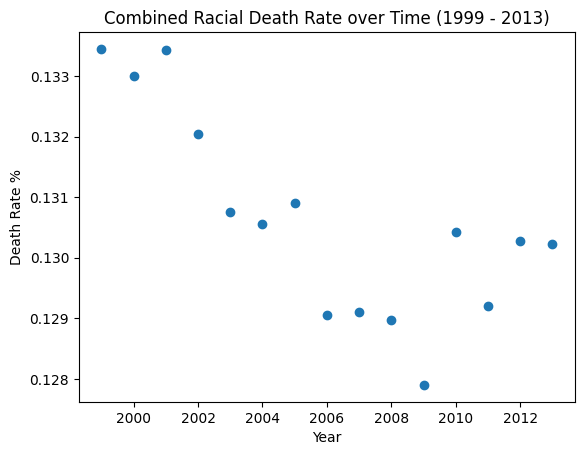

In [50]:
plt.scatter(x = death_rate_over_time.index, y = death_rate_over_time['death_rate'])
plt.title('Combined Racial Death Rate over Time (1999 - 2013)')
plt.ylabel('Death Rate %')
plt.xlabel('Year')
plt.show()

In [51]:
# H0: There is no linear relationship between time and cancer death rate.
# HA: There is a linear relationship between time and cancer death rate.



In [52]:
df['race'].unique()

array(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'White'], dtype=object)

In [53]:
# look at the death rate over time for each race separately
racial_dr_over_time = pd.DataFrame(index = range(len(df['year'].unique())))

for race in df['race'].unique():
    racial_dr_over_time[race] = df[df['race'] == race]['death_rate'].reset_index(drop = True)
racial_dr_over_time.set_index(df['year'].unique(), inplace = True)
racial_dr_over_time

,American Indian or Alaska Native,Asian or Pacific Islander,Black or African American,White
1999,0.0663,0.0791,0.1745,0.2139
2000,0.0656,0.0801,0.1724,0.2139
2001,0.0714,0.0804,0.1700,0.2119
2002,0.0690,0.0788,0.1689,0.2115
2003,0.0662,0.0799,0.1669,0.2100
2004,0.0711,0.0796,0.1644,0.2071
2005,0.0708,0.0815,0.1637,0.2076
2006,0.0681,0.0802,0.1614,0.2065
2007,0.0682,0.0812,0.1613,0.2057
2008,0.0699,0.0821,0.1586,0.2053


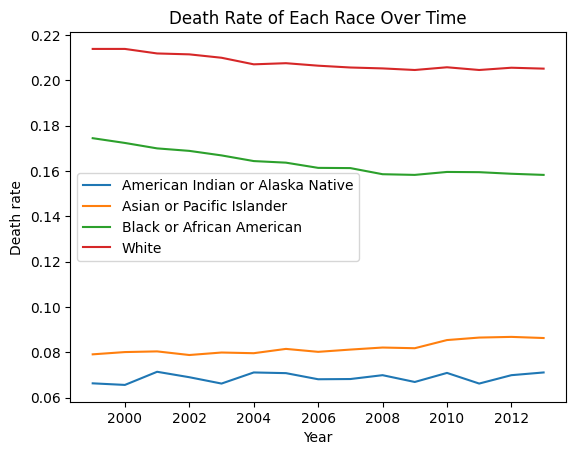

In [54]:
racial_dr_over_time.plot(xlabel="Year", ylabel="Death rate", title = 'Death Rate of Each Race Over Time')
plt.show()

Seeing how each race's death rate varies over time clarifies the combined racial death rate a little bit. Curiously, the White and Black or African American death rates have gone down, while the Asian or Pacific islander and American Indian or Alaska Native death rates have gone up. Again, the increase or decrease in death rate is quite small, only fractions of a percent.

# 